## Classification Over Text Using Naive Bayes

In [530]:
import hazm as hz
from collections import defaultdict
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import plotly.express as px

In [531]:
train_ = pd.read_csv("train.csv")


Initialize dictionary for keeping the counts of evidence words

# Evidence
 Count of each word in each category , chaining these together for each sentence for all of it's words , gives  us a probability

In [532]:
category_to_word_count = defaultdict(lambda: defaultdict(lambda: 0))


Normalize  and Lemitize and Stem the words of each sentence

In [533]:
normalizer = hz.Normalizer()
stemmer = hz.Stemmer()
lemitizer = hz.Lemmatizer()


def f(r):
    useless = ["که", "از", 'را', "شده", "در", "که", "با", "هست", "شد", "این", "به",
               "در", "دارند", "همچنین", "می‌دهد", "به", "و", "است", "آن", "شده", ".", ",", "اس", "جه", "،"]
    for e in useless:
        if (e in r):
            return False
    return True

def useless_words_filter(x):
    return [e for e in x if f(e)]

train_['Normalized'] = train_['content'].map(lambda x: normalizer.normalize(x))
train_['unary_tokens'] = train_['Normalized'].map(
    lambda x: hz.word_tokenize(x))
train_['unary_tokens'] = train_['unary_tokens'].map(
    lambda x: useless_words_filter([lemitizer.lemmatize(stemmer.stem(y)) for y in x]))


# Update Evidence

In [534]:
def update_dic_with_evidence(token, label):

    category_to_word_count[token][label] += 1


train_.apply(lambda x: list(map(lambda token: update_dic_with_evidence(
    token, x['label']), x['unary_tokens'])), axis=1)


0       [None, None, None, None, None, None, None, Non...
1       [None, None, None, None, None, None, None, Non...
2       [None, None, None, None, None, None, None, Non...
3       [None, None, None, None, None, None, None, Non...
4       [None, None, None, None, None, None, None, Non...
                              ...                        
8995    [None, None, None, None, None, None, None, Non...
8996    [None, None, None, None, None, None, None, Non...
8997    [None, None, None, None, None, None, None, Non...
8998    [None, None, None, None, None, None, None, Non...
8999    [None, None, None, None, None, None, None, Non...
Length: 9000, dtype: object

In [535]:

category_word = pd.DataFrame(category_to_word_count)
grouped_sum = category_word.transpose().sum()


In [536]:
def calculate_posterior(row, cat):
    result = (10 ** 280 )/6
    for word in row['unary_tokens']:
        if (pd.isnull(category_word[word][cat])):
            result *= (1 / len(category_word.keys()))
        else:
            result *= (category_word[word][cat] * 100 / grouped_sum[cat])
    return result 


def calculate_posterior_no_smoothing(row, cat):
    result = (10 ** 280)/6
    for word in row['unary_tokens']:
        if (pd.isnull(category_word[word][cat])):
            result *= 0
        else:
            result *= (category_word[word][cat] / grouped_sum[cat])
    return result


In [537]:

for cat in grouped_sum.keys():
    train_[
        cat + '_posterior'] = train_.apply(lambda row: calculate_posterior_no_smoothing(row, cat), axis=1)
train_["prediction"] = train_.iloc[:, 4:].idxmax(
    axis=1).map(lambda x: x.replace("_posterior", ""))


In [ ]:
def precision_score(truth,prediction):
    
    
def accuracy_score (truth,prediction):
    
    


# Confusion Matrix and Analysis of Performance of No Smoothing

Accuracy 0.7076666666666667


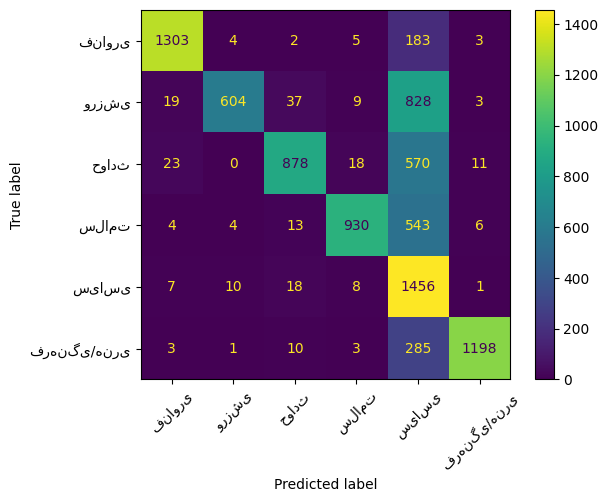

In [538]:
cf = confusion_matrix(train_['label'], train_['prediction'])
r = ConfusionMatrixDisplay(
    confusion_matrix=cf,  display_labels=list(train_['label'].unique()))
r.plot(xticks_rotation=45)
print("Accuracy " + str(accuracy_score(train_['label'], train_['prediction'])))


# Precision on Train

In [539]:
px.line(precision_score(train_['label'], train_['prediction'], average=None))


# Recall on Train 

In [540]:
px.line(recall_score(train_['label'], train_['prediction'], average=None))


In [541]:
recalls = recall_score(train_['label'], train_['prediction'], average=None)
precisions = precision_score(train_['label'], train_[
                             'prediction'], average=None)
F1 = ((recalls * precisions) * 2)/(recalls + precisions)

px.line(F1)


# Smoothing

In [542]:
for cat in grouped_sum.keys():
    train_[
        cat + '_posterior'] = train_.apply(lambda row: calculate_posterior(row, cat), axis=1)
train_["prediction"] = train_.iloc[:, 4:10].idxmax(
    axis=1).map(lambda x: x.replace("_posterior", ""))


# Confusion Matrix and Analysis of Performance of  Smoothing


Accuracy 0.9106666666666666


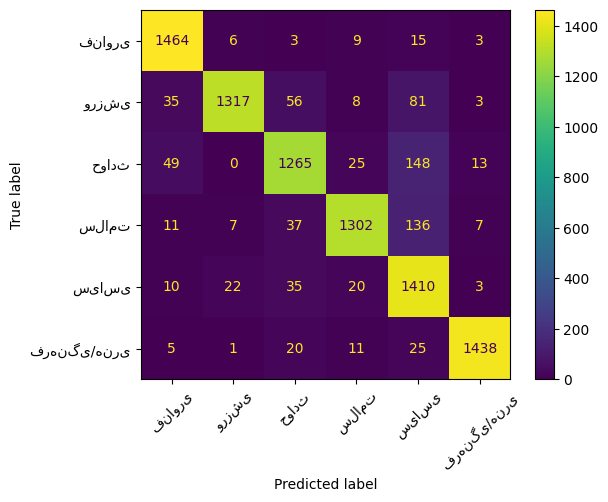

In [543]:
cf = confusion_matrix(train_['label'], train_['prediction'])
r = ConfusionMatrixDisplay(
    confusion_matrix=cf,  display_labels=list(train_['label'].unique()))
r.plot(xticks_rotation=45)
print("Accuracy " + str(accuracy_score(train_['label'], train_['prediction'])))


In [544]:
recalls= recall_score(train_['label'], train_['prediction'], average=None)
precisions = precision_score(train_['label'], train_['prediction'], average=None)
F1 = ((recalls * precisions ) * 2)/(recalls + precisions)

px.line(F1)

In [545]:
px.line(recall_score(train_['label'], train_['prediction'], average=None))


In [546]:
px.line(precision_score(train_['label'], train_['prediction'], average=None))


## As we saw smoothing had a huge improvement on alot of the scores , (Accuracy , The Confusion Matrix looks better )

## Test


In [547]:
test_ = pd.read_csv("test.csv")

test_['Normalized'] = test_['content'].map(lambda x: normalizer.normalize(x))
test_['unary_tokens'] = test_['Normalized'].map(
    lambda x: hz.word_tokenize(x))
test_['unary_tokens'] = test_['unary_tokens'].map(
    lambda x: useless_words_filter([lemitizer.lemmatize(stemmer.stem(y)) for y in x]))


In [548]:
def test_calculate_posterior(row, cat):
    result = (10 ** 150)/6
    for word in list(filter(lambda x : x in category_word.keys(),row['unary_tokens'])):
            result *= (category_word[word][cat] / grouped_sum[cat])
    return result


In [549]:

for cat in grouped_sum.keys():
    test_[
        cat + '_posterior'] = test_.apply(lambda row: test_calculate_posterior(row, cat), axis=1)


In [550]:
test_

,label,content,Normalized,unary_tokens,فناوری_posterior,سلامت_posterior,ورزشی_posterior,سیاسی_posterior,حوادث_posterior,فرهنگی/هنری_posterior
0,فناوری,بعد از اعلام لیست ۲۳ شرکت مجاز ثبت سفارش و ارا...,بعد از اعلام لیست ۲۳ شرکت مجاز ثبت سفارش و ارا...,"[بعد, اعلا, لیس, ۲۳, شرک, ثب, سفار, خد, پس, تل...",NaN,NaN,NaN,NaN,NaN,NaN
1,فرهنگی/هنری,یک استاد علم قرائت قرآن کریم، گفت: ریشه موسیقی...,یک استاد علم قرائت قرآن کریم، گفت: ریشه موسیقی...,"[یک, عل, کر, گف, :, ریشه, مقام, عرب, مبتن, بر,...",NaN,NaN,NaN,NaN,NaN,NaN
2,حوادث,آتش سوزی های زنجیره ای جنگل های زاگرس در استان...,آتش سوزی‌های زنجیره‌ای جنگل‌های زاگرس در استان...,"[آت, زنجیره, جنگل, زاگرس, ایلا, همچن, ادامه, د...",NaN,NaN,NaN,NaN,1.671384e-33,NaN
3,فناوری,استفاده از سرویس‌های iMassage یا Facetime محصو...,استفاده از سرویس‌های iMassage یا Facetime محصو...,"[iMassage, یا, Facetime, شرک, اپل, دلیل, پیامک...",0.000000e+00,NaN,NaN,NaN,NaN,NaN
4,حوادث,دادستان عمومی و انقلاب یاسوج گفت: 10 میلیون دل...,دادستان عمومی و انقلاب یاسوج گفت: ۱۰ میلیون دل...,"[دادس, انقلاب, گف, :, ۱۰, دلار, جعل, یک, شهرس,...",NaN,NaN,NaN,NaN,4.625203e-29,NaN
...,...,...,...,...,...,...,...,...,...,...
1110,ورزشی,عضو هیات مدیره باشگاه استقلال گفت:من هیچوقت به...,عضو هیات مدیره باشگاه استقلال گفت: من هیچوقت ب...,"[ه, مدیره, گف, :, من, مدیرعامل, سع, می‌کن, همی...",NaN,NaN,0.000000e+00,NaN,NaN,NaN
1111,حوادث,مدیر آموزش و پرورش شهرستان جیرفت از دستگیری دا...,مدیر آموزش و پرورش شهرستان جیرفت از دستگیری دا...,"[مدیر, شهرس, جیرف, دستگیر, دان, ضارب, معل, شهر...",NaN,NaN,NaN,2.078647e-117,NaN,2.852780e-130
1112,سیاسی,رییس جمهور با بیان اینکه در هفته گذشته هیچ شهر...,رییس جمهور با بیان اینکه در هفته گذشته هیچ شهر...,"[رییس, ب, هفته, گذشته, هیچ, شهر, قرمز, گف, :, ...",5.450285e+73,1.086087e+76,3.223507e+75,1.369693e+75,1.989837e+73,4.608447e+75
1113,فناوری,دارندگان مدل‌های اعلام‌شده گوشی‌های هوآوی، می‌...,دارندگان مدل‌های اعلام‌شده گوشی‌های هوآوی، می‌...,"[مدل, دستگاه, قابل, EROFS, GPU, Turbo, ۳٫۰, قا...",NaN,NaN,NaN,NaN,NaN,NaN
